In [1]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 6.6 MB 28.3 MB/s 
     |████████████████████████████████| 895 kB 32.7 MB/s 
     |████████████████████████████████| 77 kB 3.1 MB/s 
     |████████████████████████████████| 596 kB 40.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import os 
import random 
import time 
import torch 

import pandas as pd 
import numpy as np 
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, BertConfig 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from keras.preprocessing.sequence import pad_sequences

import datetime

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (7,094 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155501 files and d

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_excel('/content/drive/MyDrive/한국어_단발성_대화_데이터셋.xlsx')
df.head()

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38594 entries, 0 to 38593
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  38594 non-null  object
 1   Emotion   38594 non-null  object
dtypes: object(2)
memory usage: 603.2+ KB


In [8]:
df_shuffled = df.sample(frac=1).reset_index(drop=True)
df_shuffled.head()


,Sentence,Emotion
0,오 마 이 갓 오 마 이 갓오 마 이 갓,놀람
1,"그애가 전여친의 결혼이 신경쓰인댔던 그때 처음나는 , 그사람과 나의사이가 통째로 도...",놀람
2,중국을 몰라도 너무 모르는군. 역사공부를 더해야돼.,놀람
3,살 마니뺐네 ~ 이뻐졌어출산드라때. 돼지같더만~,놀람
4,위증했으면 바로 사형 시켜라,분노


In [9]:
print(df_shuffled.shape)

(38594, 2)


In [10]:
df_shuffled.loc[(df_shuffled['Emotion'] == "공포"), 'Emotion'] = 0  #공포 => 0
df_shuffled.loc[(df_shuffled['Emotion'] == "놀람"), 'Emotion'] = 1  #놀람 => 1
df_shuffled.loc[(df_shuffled['Emotion'] == "분노"), 'Emotion'] = 2  #분노 => 2
df_shuffled.loc[(df_shuffled['Emotion'] == "슬픔"), 'Emotion'] = 3  #슬픔 => 3
df_shuffled.loc[(df_shuffled['Emotion'] == "중립"), 'Emotion'] = 4  #중립 => 4
df_shuffled.loc[(df_shuffled['Emotion'] == "행복"), 'Emotion'] = 5  #행복 => 5
df_shuffled.loc[(df_shuffled['Emotion'] == "혐오"), 'Emotion'] = 6  #혐오 => 6

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


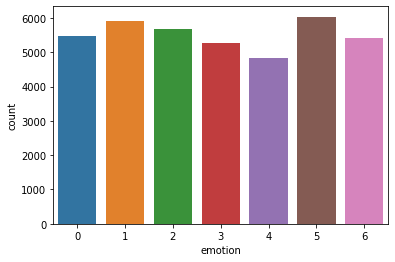

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(df_shuffled.Emotion)
plt.xlabel('emotion');

In [12]:
dataset_train, dataset_test = train_test_split(df_shuffled, test_size=0.25, random_state=0)
print(len(dataset_train))
print(len(dataset_test))


28945
9649


In [13]:
sentences = dataset_train['Sentence']
sentences = ["[CLS]" + str(s) + " [SEP]" for s in sentences]

In [14]:
sentences[:5]

['[CLS]몸에 노예근성이 배긴건지.. [SEP]',
 '[CLS]전체주의 체제로 회기하려는 국정화교과서! [SEP]',
 '[CLS]삼성내년 꼴찌 붙박이네 [SEP]',
 '[CLS]코갤 과 네이버 지금 허어어얼..0 [SEP]',
 '[CLS]후안이 무치한 뇬 [SEP]']

In [15]:
labels = dataset_train['Emotion'].values
labels = labels.astype(int)
labels.dtype

dtype('int64')

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(s) for s in sentences]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [17]:
print(sentences[0])
print(tokenized_texts[0])

[CLS]몸에 노예근성이 배긴건지.. [SEP]
['[CLS]', '몸', '##에', '노', '##예', '##근', '##성이', '배', '##긴', '##건', '##지', '.', '.', '[SEP]']


In [18]:
MAX_LEN = 64
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts ]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids[0]

array([  101,  9288, 10530,  9022, 96279, 50248, 53371,  9330, 70221,
       71439, 12508,   119,   119,   102,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [19]:

attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [20]:

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=2018, 
                                                                                    test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2018, 
                                                       test_size=0.1)

type(train_labels)

numpy.ndarray

In [21]:

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.from_numpy(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)				



In [22]:
print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([   101,   9706,  40032,  12092,   8844,  22200,  64002,  11489,   9954,
         15891,  12508,  28981,  37388,  11261,   9098,  14153, 118908,  10739,
          9405,  24974,  24683,  28911,    119,    119,    119,   9599, 119229,
        110670,  11287,    100,   9968, 119372,   9460,  38709,  48599,  10739,
        118728,    106,    106,    102,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])
tensor(6)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([   101,   9319,  50248, 119437,  11513,   9379, 118885,  14523,   8924,
          9776,  50248,  22879,    100,   96

In [23]:

batch_size = 64

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [24]:
sentences = dataset_test['Sentence']
sentences[:10]
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 아 오늘 생일이네요 ㅋㅋ [SEP]',
 '[CLS] 저게 휴대폰 사진이라고?? [SEP]',
 '[CLS] 승패를 떠나서 열심히 해주시는 여러분들을 보러 저희들은 야구장에 갑니다~!~! [SEP]',
 '[CLS] 공포의 9번 타자 유두열 [SEP]',
 '[CLS] 웰컴백!! [SEP]',
 '[CLS] 다들 그러신적 없나요? [SEP]',
 '[CLS] 숫기도없고 뭐 잘하는것도없어요 .. [SEP]',
 '[CLS] 서류부터 이미 다 까일까요? [SEP]',
 '[CLS] 단일경기 최다득점 오늘로써 1위 바뀌었슴요...골스가 149점..ㅎㄷㄷ [SEP]',
 '[CLS] 머리 ㅋㅋㅋㅋㅋㅋㅋ캐릭터 있음ㅋㅋㅋㅋㅋ [SEP]']

In [25]:
labels = dataset_test['Emotion'].values
labels = labels.astype(int)
labels.dtype


dtype('int64')

In [26]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

[CLS] 아 오늘 생일이네요 ㅋㅋ [SEP]
['[CLS]', '아', '오', '##늘', '생', '##일', '##이', '##네', '##요', '[UNK]', '[SEP]']


In [27]:

MAX_LEN = 64


input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]


input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   9519,   9580, 118762,   9420,  18392,  10739,  77884,
        48549,    100,    102,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0])

In [28]:

attention_masks = []


for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [29]:
# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

tensor([   101,   9519,   9580, 118762,   9420,  18392,  10739,  77884,  48549,
           100,    102,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])
tensor(5)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [30]:

batch_size = 64

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [31]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [32]:

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [33]:

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=7)
model.cuda()

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [34]:

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8
                )


epochs = 5

total_steps = len(train_dataloader) * epochs


scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [35]:


def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [36]:

def format_time(elapsed):

    elapsed_rounded = int(round((elapsed)))
    
  
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [37]:

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.zero_grad()


for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    t0 = time.time()


    total_loss = 0


    model.train()
        

    for step, batch in enumerate(train_dataloader):
 
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        batch = tuple(t.to(device) for t in batch)
        

        b_input_ids, b_input_mask, b_labels = batch

          
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
     
        loss = outputs[0]

        total_loss += loss.item()

   
        loss.backward()

   
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

 
        model.zero_grad()


    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()


    model.eval()

   
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0


    for batch in validation_dataloader:
   
        batch = tuple(t.to(device) for t in batch)
 
        b_input_ids, b_input_mask, b_labels = batch
        
    
        with torch.no_grad():     
     
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
      
        logits = outputs[0]

     
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
  
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...

  Average training loss: 1.57
  Training epcoh took: 0:09:01

Running Validation...
  Accuracy: 0.46
  Validation took: 0:00:20

======== Epoch 2 / 5 ========
Training...

  Average training loss: 1.33
  Training epcoh took: 0:08:56

Running Validation...
  Accuracy: 0.49
  Validation took: 0:00:19

======== Epoch 3 / 5 ========
Training...

  Average training loss: 1.20
  Training epcoh took: 0:08:56

Running Validation...
  Accuracy: 0.50
  Validation took: 0:00:19

======== Epoch 4 / 5 ========
Training...

  Average training loss: 1.09
  Training epcoh took: 0:08:55

Running Validation...
  Accuracy: 0.50
  Validation took: 0:00:19

======== Epoch 5 / 5 ========
Training...

  Average training loss: 1.02
  Training epcoh took: 0:08:55

Running Validation...
  Accuracy: 0.50
  Validation took: 0:00:19

Training complete!


In [38]:

t0 = time.time()


model.eval()


eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0


for step, batch in enumerate(test_dataloader):
    
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

 
    batch = tuple(t.to(device) for t in batch)
    
   
    b_input_ids, b_input_mask, b_labels = batch
    
 
    with torch.no_grad():     
      
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
   
    logits = outputs[0]

  
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

  Batch   100  of    151.    Elapsed: 0:00:43.

Accuracy: 0.50
Test took: 0:01:05


In [39]:

def convert_input_data(sentences):


    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

   
    MAX_LEN = 128


    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
   
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    
    attention_masks = []

    
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

  
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [40]:

def test_sentences(sentences):


    model.eval()

    inputs, masks = convert_input_data(sentences)

 
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
 
    with torch.no_grad():     
 
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

   
    logits = logits.detach().cpu().numpy()

    return logits

In [41]:
def predict(logits):
  test_eval=[]
  if np.argmax(logits) == 0:
    test_eval.append("공포가")
  elif np.argmax(logits) == 1:
    test_eval.append("놀람이")
  elif np.argmax(logits) == 2:
    test_eval.append("분노가")
  elif np.argmax(logits) == 3:
    test_eval.append("슬픔이")
  elif np.argmax(logits) == 4:
    test_eval.append("중립이")
  elif np.argmax(logits) == 5:
    test_eval.append("행복이")
  elif np.argmax(logits) == 6:
    test_eval.append("혐오가")
  print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")


In [46]:
logits = test_sentences(['공부하기 싫다'])

print(logits)
print(np.argmax(logits))
print(predict(logits))

[[-0.8541476  -1.9604208   1.0456544   1.7311229  -0.16508579 -1.0231408
   1.2854722 ]]
3
>> 입력하신 내용에서 슬픔이 느껴집니다.
None


In [ ]:
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == 0 :
        break
    logits = test_sentences([sentence])    
    predict(logits)
    print("\n")

하고싶은 말을 입력해주세요 : 어두운게 너무 무섭더라
>> 입력하신 내용에서 공포가 느껴집니다.


하고싶은 말을 입력해주세요 : 주식이 엄청 올렸더라?!
>> 입력하신 내용에서 놀람이 느껴집니다.


하고싶은 말을 입력해주세요 : 마스크 때문에 너무 짜증나
>> 입력하신 내용에서 혐오가 느껴집니다.


하고싶은 말을 입력해주세요 : 코로나는 대체 언제 없어지는거야?
>> 입력하신 내용에서 슬픔이 느껴집니다.


하고싶은 말을 입력해주세요 : 요즘 화가 많이 나
>> 입력하신 내용에서 분노가 느껴집니다.


하고싶은 말을 입력해주세요 : 우산 챙겨가~
>> 입력하신 내용에서 중립이 느껴집니다.


하고싶은 말을 입력해주세요 : 오늘 날씨가 너무 맑다!
>> 입력하신 내용에서 행복이 느껴집니다.


하고싶은 말을 입력해주세요 : 으 벌레 너무 싫어
>> 입력하신 내용에서 혐오가 느껴집니다.




In [ ]:
코로